## File for fitting EDES to all the sets generated for MIR, LIR and healthy populations

In [121]:
# load packages and files
using DifferentialEquations, SciMLBase, Plots, Random # for solving ODEs
using DataFrames
using DataStructures # for the OrderedDict
using LatinHypercubeSampling # for the LHS
using Trapz # for the trapezoidal rule
using CSV # for reading in the parameter distributions of the Ohashi
using Statistics # for the mean and std functions
using JLD2 # for saving the results
rng_test =  Random.seed!(1234) # testing
rng_training = Random.seed!(2) # training
save_boolean = true # for saving the results

include("../EDES/including.jl") # for the EDES model 


PlotMealResponseProgression (generic function with 2 methods)

#### Load Data

Combined the data into test and training set

Add the state as healthy == 2, MIR == 1, LIR == 0

Make new IDs for seperate test and training set

In [122]:


# Load the data
healthy_training = DataFrame(CSV.File("./Metadata/Training_OGTT_healthy.csv"))
MIR_training = DataFrame(CSV.File("./Metadata/Training_OGTT_MIR.csv"))
LIR_training = DataFrame(CSV.File("./Metadata/Training_OGTT_LIR.csv"))

healthy_test = DataFrame(CSV.File("./Metadata/Test_OGTT_healthy.csv"))
MIR_test = DataFrame(CSV.File("./Metadata/Test_OGTT_MIR.csv"))
LIR_test = DataFrame(CSV.File("./Metadata/Test_OGTT_LIR.csv"))

# Add a new column with labels
healthy_training.state .= 2
MIR_training.state .= 1
LIR_training.state .= 0

healthy_test.state .= 2
MIR_test.state .= 1
LIR_test.state .= 0

# Ensure that the number of rows in each dataset is a multiple of 6
@assert nrow(LIR_training) % 6 == 0
@assert nrow(MIR_training) % 6 == 0
@assert nrow(healthy_training) % 6 == 0

# Combine data in blocks of 6 rows and adjust IDs
block_size = 6

# Interleave the rows for the training set, grouping 6 rows from each and assigning same ID for each block
training_set = DataFrame()
id_counter = 1  # Initialize ID counter
for i in 1:block_size:nrow(LIR_training)
    # For each block of 6 rows
    block_LIR = LIR_training[i:i+block_size-1, :]
    block_MIR = MIR_training[i:i+block_size-1, :]
    block_healthy = healthy_training[i:i+block_size-1, :]
    
    # Assign the same ID for all rows within the block
    block_LIR.Patient_ID .= id_counter
    block_MIR.Patient_ID .= id_counter+1
    block_healthy.Patient_ID .= id_counter+2
    
    # Update the ID counter (move to the next ID for the next block)
    id_counter += 3
    
    # Append to the final interleaved DataFrame
    append!(training_set, block_LIR)
    append!(training_set, block_MIR)
    append!(training_set, block_healthy)
end

# For testing sets, repeat the same logic
@assert nrow(LIR_test) % 6 == 0
@assert nrow(MIR_test) % 6 == 0
@assert nrow(healthy_test) % 6 == 0

test_set = DataFrame()
id_counter = 1  # Reset ID counter for testing set
for i in 1:block_size:nrow(LIR_test)
    # For each block of 6 rows
    block_LIR = LIR_test[i:i+block_size-1, :]
    block_MIR = MIR_test[i:i+block_size-1, :]
    block_healthy = healthy_test[i:i+block_size-1, :]
    
    # Assign the same ID for all rows within the block
    block_LIR.Patient_ID .= id_counter
    block_MIR.Patient_ID .= id_counter+1
    block_healthy.Patient_ID .= id_counter+2
    
    # Update the ID counter (move to the next ID for the next block)
    id_counter += 3
    
    # Append to the final interleaved DataFrame
    append!(test_set, block_LIR)
    append!(test_set, block_MIR)
    append!(test_set, block_healthy)
end

# Now, interleaved_training and interleaved_test contain the data in the desired order with the same ID for each block
training_set

Row,Patient_ID,Long_Time,glucose_t_0,glucose_t_15,glucose_t_30,glucose_t_60,glucose_t_120,glucose_t_180,glucose_t_240,insulin_t_0,insulin_t_15,insulin_t_30,insulin_t_60,insulin_t_120,insulin_t_180,insulin_t_240,state
,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Int64
1,1,0,5.04384,5.35895,5.3866,5.23357,5.02516,4.99084,4.99244,9.09879,16.2187,24.7139,31.3914,23.1989,15.8888,13.4681,0
2,1,6,5.18522,5.77299,5.95195,5.61477,5.06665,4.96173,4.96168,9.48486,24.0055,45.6074,65.573,47.453,28.3138,21.618,0
3,1,12,5.30406,6.35804,7.09142,6.52358,5.14934,4.87788,4.88147,9.62312,34.5628,81.5721,137.302,100.054,53.2161,36.7801,0
4,1,18,5.37818,6.80285,8.25205,7.78199,5.14209,4.67436,4.7295,10.0163,42.7143,114.111,221.443,160.461,72.8666,44.878,0
5,1,24,5.64285,7.52154,10.2664,11.3557,5.79433,3.90328,4.00523,10.2105,57.1328,168.915,408.685,372.992,144.632,52.0154,0
6,1,30,5.77062,7.30559,9.35187,9.62538,5.61333,4.46758,4.50497,10.5517,54.9644,148.12,321.902,278.612,127.458,69.8081,0
7,2,0,5.2697,5.49449,5.81351,5.90515,5.39216,4.90054,4.80309,10.3987,17.9739,29.4297,41.4873,40.0525,25.353,14.8263,1
8,2,6,5.26377,5.53406,6.06951,6.45618,5.68335,4.81359,4.53747,10.5205,19.0152,36.2693,61.1398,63.6566,40.5955,20.5358,1
9,2,12,5.44234,5.68784,6.3323,7.17078,6.26605,4.84472,4.19359,11.1149,22.0406,43.85,86.1811,102.946,71.4553,36.8995,1


In [123]:
training_set

Row,Patient_ID,Long_Time,glucose_t_0,glucose_t_15,glucose_t_30,glucose_t_60,glucose_t_120,glucose_t_180,glucose_t_240,insulin_t_0,insulin_t_15,insulin_t_30,insulin_t_60,insulin_t_120,insulin_t_180,insulin_t_240,state
,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Int64
1,1,0,5.04384,5.35895,5.3866,5.23357,5.02516,4.99084,4.99244,9.09879,16.2187,24.7139,31.3914,23.1989,15.8888,13.4681,0
2,1,6,5.18522,5.77299,5.95195,5.61477,5.06665,4.96173,4.96168,9.48486,24.0055,45.6074,65.573,47.453,28.3138,21.618,0
3,1,12,5.30406,6.35804,7.09142,6.52358,5.14934,4.87788,4.88147,9.62312,34.5628,81.5721,137.302,100.054,53.2161,36.7801,0
4,1,18,5.37818,6.80285,8.25205,7.78199,5.14209,4.67436,4.7295,10.0163,42.7143,114.111,221.443,160.461,72.8666,44.878,0
5,1,24,5.64285,7.52154,10.2664,11.3557,5.79433,3.90328,4.00523,10.2105,57.1328,168.915,408.685,372.992,144.632,52.0154,0
6,1,30,5.77062,7.30559,9.35187,9.62538,5.61333,4.46758,4.50497,10.5517,54.9644,148.12,321.902,278.612,127.458,69.8081,0
7,2,0,5.2697,5.49449,5.81351,5.90515,5.39216,4.90054,4.80309,10.3987,17.9739,29.4297,41.4873,40.0525,25.353,14.8263,1
8,2,6,5.26377,5.53406,6.06951,6.45618,5.68335,4.81359,4.53747,10.5205,19.0152,36.2693,61.1398,63.6566,40.5955,20.5358,1
9,2,12,5.44234,5.68784,6.3323,7.17078,6.26605,4.84472,4.19359,11.1149,22.0406,43.85,86.1811,102.946,71.4553,36.8995,1


## FIT for training set


In [124]:
using Distributed

n_cores = length(Sys.cpu_info())

# note that this is the same as of the synthetic patients, needs to change if we start changing the weight or the dose
BW = 70 
G_dose::Real = 75000.0
time_G = [0,15,30,60,120,180,240]
time_I = [0,15,30,60,120,180,240]

if nprocs()-1 < n_cores
    addprocs(n_cores-nprocs()+1, exeflags="--project")
end

@everywhere begin
    using DifferentialEquations, SciMLBase, Plots, Random # for solving ODEs
    using Optimization, OptimizationOptimJL, LineSearches # for optimization
    using QuasiMonteCarlo # for LHS
    using Trapz
    include("../EDES/including.jl")
end

columnnames = ["Patient_ID","Long_time_points","Health status","k1","k5","k6"]



patients = [[collect(training_set[j,3:9]), collect(training_set[j,10:16]), BW, G_dose, time_G, time_I] for j in 1:nrow(training_set)]
results = pmap(x -> ParameterEstimation(x...), patients)

# close the parallel pool
rmprocs(procs()[2:end])

# add the ID, health status and the long time points to the results
# add the ID, health status and the long time points to the results
for i in 1:length(results)
    results[i] = [training_set[i,1], training_set[i,2], training_set[i,17], results[i]...]
end

results = DataFrame(reduce(hcat, results)', Symbol.(columnnames))

# save as a CSV file
if save_boolean
    CSV.write("./Metadata/Training_EDES_fits.csv", results)
end



      From worker 37:	Optimization successful! continuing...
      From worker 37:	Parameter estimation done!
      From worker 39:	Optimization successful! continuing...
      From worker 41:	Optimization successful! continuing...
      From worker 39:	Parameter estimation done!
      From worker 41:	Parameter estimation done!
      From worker 35:	Optimization successful! continuing...
      From worker 35:	Parameter estimation done!
      From worker 40:	Optimization successful! continuing...
      From worker 40:	Parameter estimation done!
      From worker 34:	Optimization successful! continuing...
      From worker 34:	Parameter estimation done!
      From worker 38:	Optimization successful! continuing...
      From worker 38:	Parameter estimation done!
      From worker 36:	Optimization successful! continuing...
      From worker 36:	Parameter estimation done!
      From worker 41:	Optimization successful! continuing...
      From worker 41:	Parameter estimation done!
      From

"./Metadata/Training_EDES_fits.csv"

In [186]:
#select all health status of 1 from results and describe the distribution
MIR = results[results."Health status" .== 1, :]

describe(MIR)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Float64,Float64,Float64,Int64,DataType
1,Patient_ID,75.5,2.0,75.5,149.0,0,Float64
2,Long_time_points,15.0,0.0,15.0,30.0,0,Float64
3,Health status,1.0,1.0,1.0,1.0,0,Float64
4,k1,0.0337585,0.0138705,0.0146085,0.417759,0,Float64
5,k5,0.188969,0.00597015,0.0573233,1.5,0,Float64
6,k6,1.9536,0.354246,0.817474,10.0,0,Float64


In [173]:
datapoints.glc

7-element Vector{Float64}:
 5.376220402800482
 5.684783989204468
 6.386283654567302
 7.6089567920848555
 7.417502457476342
 6.081043325162432
 5.077999309557848

### visualise some fits

0.01423168818424357
0.02569576959906072
0.5202434415416047

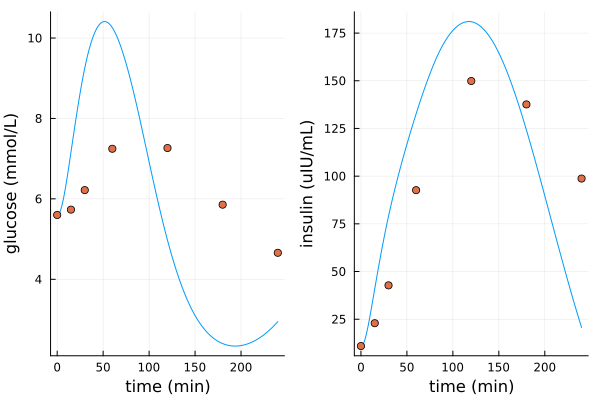

In [187]:
include("../EDES/including.jl")
patient_n = 58

k1_MIR = MIR[patient_n, :k1]
k5_MIR = MIR[patient_n, :k5]
k6_MIR = MIR[patient_n, :k6]
println(k1_MIR)
println(k5_MIR)
print(k6_MIR)
parameter_values = [k1_MIR, k5_MIR, k6_MIR]
param_names = ["k1", "k5", "k6"]

datapoints = (time = [0,15,30,60,120,180,240],glc = reduce(vcat, MIR_training[patient_n, 3:9]), ins = reduce(vcat, MIR_training[patient_n, 10:16]))
fasting_glucose = datapoints.glc[1]
fasting_insulin = datapoints.ins[1]


PlotMealResponse(param_names, parameter_values, datapoints, fasting_glucose, fasting_insulin)